In [2]:
import os
import time
import argparse
import functools

import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [26, 14]

from pprint import pprint
from collections import namedtuple
from collections import OrderedDict
from recordclass import recordclass
from multiprocessing.pool import ThreadPool

from typing import List

from dataclasses import dataclass, field

CPUS= mp.cpu_count()
LOCK = mp.Lock()

In [3]:
EXP_NAME = "samelength_client_attacker_100kbps_100vs100conns_8000_microcloud"

EXP_CSV = f"{EXP_NAME}.csv"
EXP_DIR = f"/home/ubuntu/californium/deter/expdata/real/proxy/{EXP_NAME}"

ATTACKER_IPS = { "10.1.2.2" }
CLIENT_IPS   = { "10.1.1.2" }
RECEIVER_IPS = { "10.1.4.3" }
SERVER_IPS   = { "10.1.3.3" }
PROXY_IPS    = { "10.1.1.3", "10.1.2.3", "10.1.3.2", "10.1.4.2" }

In [4]:
@dataclass
class TopInfo:
  pct_mems:      List[float]
  pct_cpus:      List[float]
  timestamps:    List[int]
  min_timestamp: int

_trial_data_fields = [
    "top_info",
    "main_df", 
    "attacker_df",
    "attacker_to_proxy_df",
    "proxy_df",
    "proxy_from_attacker_df",
    "proxy_to_server_df",
    "proxy_from_server_df",
    "proxy_to_receiver_df",
    "server_df",
    "server_from_proxy_df",
    "server_to_proxy_df",
    "receiver_df",
    "receiver_from_proxy_df",
    "receiver_from_proxy_success_df",
    "receiver_from_proxy_failure_df",
    
    "client_df",
    "client_to_proxy_df",
    "client_to_proxy_retransmissions_df",
    "client_from_proxy_df",
    "proxy_from_client_df",
    "proxy_to_client_df",
    "client_from_proxy_success_df",
    "client_from_proxy_failure_df",
    
    "attacker_message_numbers",
    "client_message_numbers",
    
    "proxy_to_server_client_df",
    "proxy_to_server_attacker_df",
    "proxy_from_server_client_df",
    "proxy_from_server_attacker_df",
    
    "server_from_proxy_client_df",
    "server_from_proxy_attacker_df",
    "server_to_proxy_client_df",
    "server_to_proxy_attacker_df"
]
TrialData = recordclass("TrialData", _trial_data_fields, defaults=(None,)*len(_trial_data_fields))

In [5]:
def load_and_prepare_csv(csvfile):
    df = pd.read_csv(csvfile).replace(np.nan, "", regex=True)
    
    df["coap_code"] = df["coap_code"].astype(str)
    df["coap_token"] = df["coap_token"].astype(str)
    
    min_timestamp = df["message_timestamp"].min()
    df["relative_timestamp"] = df["message_timestamp"] - min_timestamp
    
    df.sort_values(by="message_timestamp", inplace=True)
    
    return df

def load_top(topfile, run_number):
  top_info = TopInfo(pct_mems=[], pct_cpus=[], timestamps=[], min_timestamp=float('inf'))

  with open(topfile, 'r') as f:
    last_timestamp = None
    for L in f:
      parts = L.split()

      # The timestamp line always precedes process lines
      if L.startswith("top -"):
        # Parse timstamp to seconds
        timestamp_string = parts[2]
        hh, mm, ss = map(int, timestamp_string.split(':'))
        last_timestamp = (3600 * hh)
        last_timestamp += (60 * mm)
        last_timestamp += ss
        
        # Update smallest timestamp found
        top_info.min_timestamp = min(top_info.min_timestamp, last_timestamp)

      # Parse util metrics and combine with above timestamp
      if "java" in L:
        pct_mem = float(parts[-3])
        pct_cpu = float(parts[-4])
        # Record the top info
        top_info.pct_mems.append(pct_mem)
        top_info.pct_cpus.append(pct_cpu)
        top_info.timestamps.append(last_timestamp)

  return top_info

def pct_containment(A, B):
    try:
        return 100 * len(A & B) / len(A)
    except ZeroDivisionError:
        return 0

In [6]:
# Read in trial data

start = time.time()

trials = OrderedDict()

def get_td_from_trial(tdn):
    LOCK.acquire()
    print(f"{tdn}...")
    LOCK.release()
    
    exp_csv_path = f"{EXP_DIR}/{tdn}/{EXP_CSV}"
    proxy_top_file = f"{EXP_DIR}/{tdn}/proxy.top"

    # Parse/load information from top
    try:
        top_info = load_top(proxy_top_file, tdn)
    except FileNotFoundError:
        top_info = None
    
    # Parse/load information from experiment csv
    main_df = load_and_prepare_csv(exp_csv_path)
    
    td = TrialData(main_df=main_df, top_info=top_info)
    
    LOCK.acquire()
    print(f"{tdn} Done!")
    LOCK.release()
    
    return (td, tdn)


trial_dir_names = list(map(int, sorted(filter(str.isnumeric, os.listdir(EXP_DIR)), key=int)))

with ThreadPool(CPUS) as pool:
    td_tdns = pool.map(get_td_from_trial, trial_dir_names)
    for td, tdn in td_tdns:
        trials[tdn] = td
print("DONE")

finish = time.time()

print(f"Execution took {finish - start} seconds")

1...
2...
3...


/usr/lib/python3.6/multiprocessing/pool.py:119: DtypeWarning: Columns (7,8,10,11,14,15,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  result = (True, func(*args, **kwds))
/usr/lib/python3.6/multiprocessing/pool.py:119: DtypeWarning: Columns (11,14,15,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  result = (True, func(*args, **kwds))


1 Done!
3 Done!
2 Done!
DONE
Execution took 3.5857937335968018 seconds


1...
2...
3...


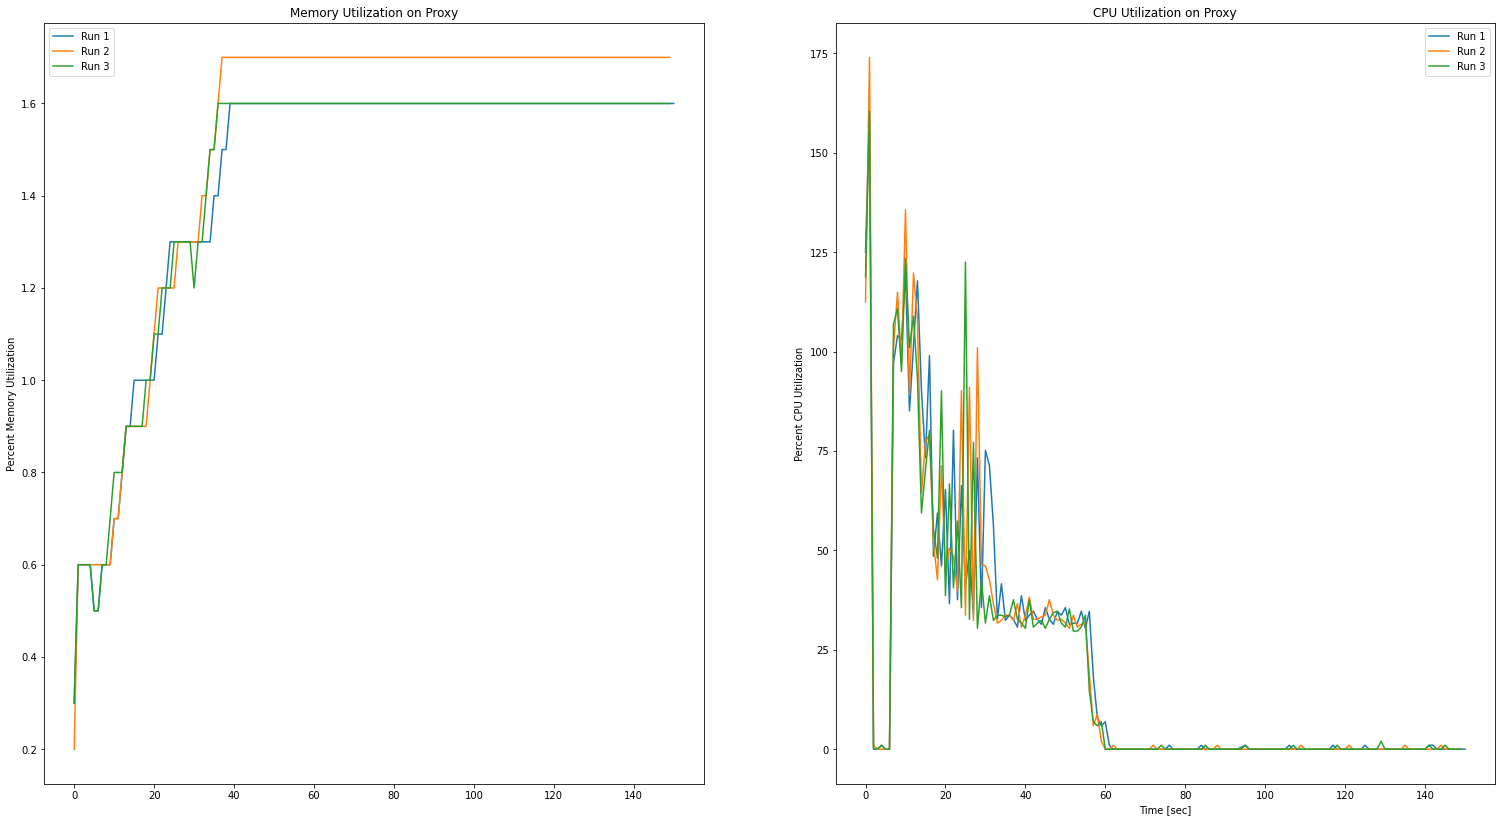

In [7]:
# Graph top
fig, ax = plt.subplots(1, 2)

for trial_number, trial_data in sorted(trials.items()):
    if not trial_data.top_info:
        continue
    print(f"{trial_number}...")
    min_timestamp = trial_data.top_info.min_timestamp
    top_time = [ t - min_timestamp for t in trial_data.top_info.timestamps ]
    top_cpu  = trial_data.top_info.pct_cpus
    top_mem  = trial_data.top_info.pct_mems

    ax[0].plot(top_time, top_mem, label=f"Run {trial_number}")
    ax[0].set_title("Memory Utilization on Proxy")
    ax[1].set_xlabel("Time [sec]")
    ax[0].set_ylabel("Percent Memory Utilization")
    ax[0].legend()

    ax[1].plot(top_time, top_cpu, label=f"Run {trial_number}")
    ax[1].set_title("CPU Utilization on Proxy")
    ax[1].set_xlabel("Time [sec]")
    ax[1].set_ylabel("Percent CPU Utilization")
    ax[1].legend()

plt.show()

In [8]:
# Define filters

# Node Type
attacker_node_mask = lambda df: df["node_type"] == "attacker"
proxy_node_mask = lambda df: df["node_type"] == "proxy"
server_node_mask = lambda df: df["node_type"] == "server"
receiver_node_mask = lambda df: df["node_type"] == "receiver"
client_node_mask = lambda df: df["node_type"] == "client"

# CoAP
coap_protocol = lambda df: df["message_protocol"] == "coap"
coap_get_code = lambda df: df["coap_code"] == "get"
coap_retransmission = lambda df: df["coap_retransmitted"] == 1.0
coap_content_code = lambda df: df["coap_code"] == "content"
coap_content_not_code = lambda df: df["coap_code"] != "content"

# HTTP
http_protocol = lambda df: df["message_protocol"] == "http"
http_get_request = lambda df: df["http_request_method"] == "get"
http_response = lambda df: df["http_response"]

# Source and Destination IP
proxy_src_mask = lambda df: df["message_source"].isin(PROXY_IPS)
proxy_dst_mask = lambda df: df["message_destination"].isin(PROXY_IPS)

server_src_mask = lambda df: df["message_source"].isin(SERVER_IPS)
server_dst_mask = lambda df: df["message_destination"].isin(SERVER_IPS)

receiver_src_mask = lambda df: df["message_source"].isin(RECEIVER_IPS)
receiver_dst_mask = lambda df: df["message_destination"].isin(RECEIVER_IPS)

client_src_mask = lambda df: df["message_source"].isin(CLIENT_IPS)
client_dst_mask = lambda df: df["message_destination"].isin(CLIENT_IPS)

In [9]:
# Add filtration layers to each trial data
for i, (tn, td) in enumerate(sorted(trials.items())):
    print(f"{tn}...")
    main_df = td.main_df[td.main_df["message_number"] != -1]
    
    # Attacker
    td.attacker_df = main_df[attacker_node_mask(main_df)]
    td.attacker_to_proxy_df = td.attacker_df[proxy_dst_mask(td.attacker_df)]
    
    # Client
    td.client_df = main_df[client_node_mask(main_df)]
    td.client_to_proxy_df = td.client_df[coap_protocol(td.client_df)
                                         & coap_get_code(td.client_df)]
    # Account for retransmissions
    td.client_to_proxy_retransmissions_df = td.client_to_proxy_df[coap_retransmission(td.client_to_proxy_df)]
    td.client_from_proxy_df = td.client_df[coap_protocol(td.client_df)
                                           & ~coap_get_code(td.client_df)]
    td.client_from_proxy_success_df = td.client_from_proxy_df[coap_content_code(td.client_from_proxy_df)]
    td.client_from_proxy_failure_df = td.client_from_proxy_df[coap_content_not_code(td.client_from_proxy_df)]
    
    # Message Numbers
    td.attacker_message_numbers = set(td.attacker_to_proxy_df.message_number.unique())
    td.client_message_numbers = set(td.client_to_proxy_df.message_number.unique())
    assert len(td.attacker_message_numbers & td.client_message_numbers) == 0
    
    # Message Number Filters
    has_attacker_msgs = lambda df: df["message_number"].isin(td.attacker_message_numbers)
    has_client_msgs = lambda df: df["message_number"].isin(td.client_message_numbers)

    # Proxy
    td.proxy_df = main_df[proxy_node_mask(main_df)]
    td.proxy_from_attacker_df = td.proxy_df[(coap_protocol(td.proxy_df)) 
                                          & (coap_get_code(td.proxy_df)) 
                                          & (receiver_src_mask(td.proxy_df))
                                          & (proxy_dst_mask(td.proxy_df))]
    td.proxy_from_client_df = td.proxy_df[(coap_protocol(td.proxy_df)) 
                                          & (coap_get_code(td.proxy_df)) 
                                          & (client_src_mask(td.proxy_df))
                                          & (proxy_dst_mask(td.proxy_df))]
    
    td.proxy_to_server_df = td.proxy_df[(http_protocol(td.proxy_df))
                                      & (http_get_request(td.proxy_df))
                                      & (proxy_src_mask(td.proxy_df))
                                      & (server_dst_mask(td.proxy_df))]
    # Two sources are sending to server via proxy
    td.proxy_to_server_client_df = td.proxy_to_server_df[(has_client_msgs(td.proxy_to_server_df))]
    td.proxy_to_server_attacker_df = td.proxy_to_server_df[(has_attacker_msgs(td.proxy_to_server_df))]
    
    td.proxy_from_server_df = td.proxy_df[(http_protocol(td.proxy_df)) 
                                        & (http_response(td.proxy_df)) 
                                        & (proxy_dst_mask(td.proxy_df))]
    # Two sources are receiving from server via proxy
    td.proxy_from_server_client_df = td.proxy_from_server_df[has_client_msgs(td.proxy_from_server_df)]
    td.proxy_from_server_attacker_df = td.proxy_from_server_df[has_attacker_msgs(td.proxy_from_server_df)]
    
    td.proxy_to_client_df = td.proxy_df[(coap_protocol(td.proxy_df)) 
                                        & (client_dst_mask(td.proxy_df))]
    td.proxy_to_receiver_df = td.proxy_df[(coap_protocol(td.proxy_df)) 
                                        & (receiver_dst_mask(td.proxy_df))]

    # Server
    td.server_df = main_df[server_node_mask(main_df)]
    
    td.server_from_proxy_df = td.server_df[(http_protocol(td.server_df)) 
                                        & (http_get_request(td.server_df)) 
                                        & (proxy_src_mask(td.server_df))]
    # Two sources are sending to server via proxy
    td.server_from_proxy_client_df = td.server_from_proxy_df[has_client_msgs(td.server_from_proxy_df)]
    td.server_from_proxy_attacker_df = td.server_from_proxy_df[has_attacker_msgs(td.server_from_proxy_df)]
    
    td.server_to_proxy_df = td.server_df[(http_protocol(td.server_df)) 
                                      & (http_response(td.server_df)) 
                                      & (proxy_dst_mask(td.server_df))]
    # Two sources are sending back to proxy from server
    td.server_to_proxy_client_df = td.server_to_proxy_df[has_client_msgs(td.server_to_proxy_df)]
    td.server_to_proxy_attacker_df = td.server_to_proxy_df[has_attacker_msgs(td.server_to_proxy_df)]

    # Receiver
    td.receiver_df = main_df[receiver_node_mask(main_df)]
    td.receiver_from_proxy_df = td.receiver_df[proxy_src_mask(td.receiver_df)
                                              & (receiver_dst_mask(td.receiver_df))]
    td.receiver_from_proxy_success_df = td.receiver_from_proxy_df[coap_content_code(td.receiver_from_proxy_df)]
    td.receiver_from_proxy_failure_df = td.receiver_from_proxy_df[coap_content_not_code(td.receiver_from_proxy_df)]
    
    print(f"{tn} Done!")

1...
1 Done!
2...
2 Done!
3...
3 Done!


In [10]:
# TODO: Filtration assertions

In [11]:
td = trials[1]
df = td.main_df

df

,node_type,message_number,message_timestamp,message_source,message_destination,message_protocol,message_size,coap_type,coap_code,coap_message_id,...,coap_proxy_uri,coap_retransmitted,http_request,http_request_method,http_request_full_uri,http_response,http_response_code,http_response_code_desc,http_response_for_uri,relative_timestamp
0,client,1,1.617126e+09,10.1.1.2,10.1.1.3,coap,106,con,get,1,...,http://10.1.3.3:80/1_09D418E2EB96DA10,0,,,,,,,,0.000000
42994,proxy,1,1.617126e+09,10.1.1.2,10.1.1.3,coap,106,con,get,1,...,http://10.1.3.3:80/1_09D418E2EB96DA10,0,,,,,,,,0.028097
149349,server,1,1.617126e+09,10.1.3.2,10.1.3.3,http,204,,,,...,,,1,get,http://10.1.3.3:80/1_09D418E2EB96DA10,0,,,,0.048872
149350,server,1,1.617126e+09,10.1.3.3,10.1.3.2,http,473,,,,...,,,0,,,1,200,OK,http://10.1.3.3:80/1_09D418E2EB96DA10,0.049515
149351,server,2,1.617126e+09,10.1.3.2,10.1.3.3,http,204,,,,...,,,1,get,http://10.1.3.3:80/2_4BBCC68D3454F788,0,,,,0.080971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143125,proxy,24606,1.617126e+09,10.1.4.2,10.1.4.3,coap,74,ack,content,37054,...,,0,,,,,,,,53.355979
143126,proxy,24607,1.617126e+09,10.1.4.3,10.1.2.3,coap,107,con,get,37055,...,http://10.1.3.3:80/37055_da09cc2d,0,,,,,,,,53.362616
143127,proxy,24607,1.617126e+09,10.1.3.2,10.1.3.3,http,200,,,,...,,,1,get,http://10.1.3.3:80/37055_da09cc2d,0,,,,53.362882
143128,proxy,24607,1.617126e+09,10.1.3.3,10.1.3.2,http,472,,,,...,,,0,,,1,200,OK,http://10.1.3.3:80/37055_da09cc2d,53.364253


1...
2...
3...


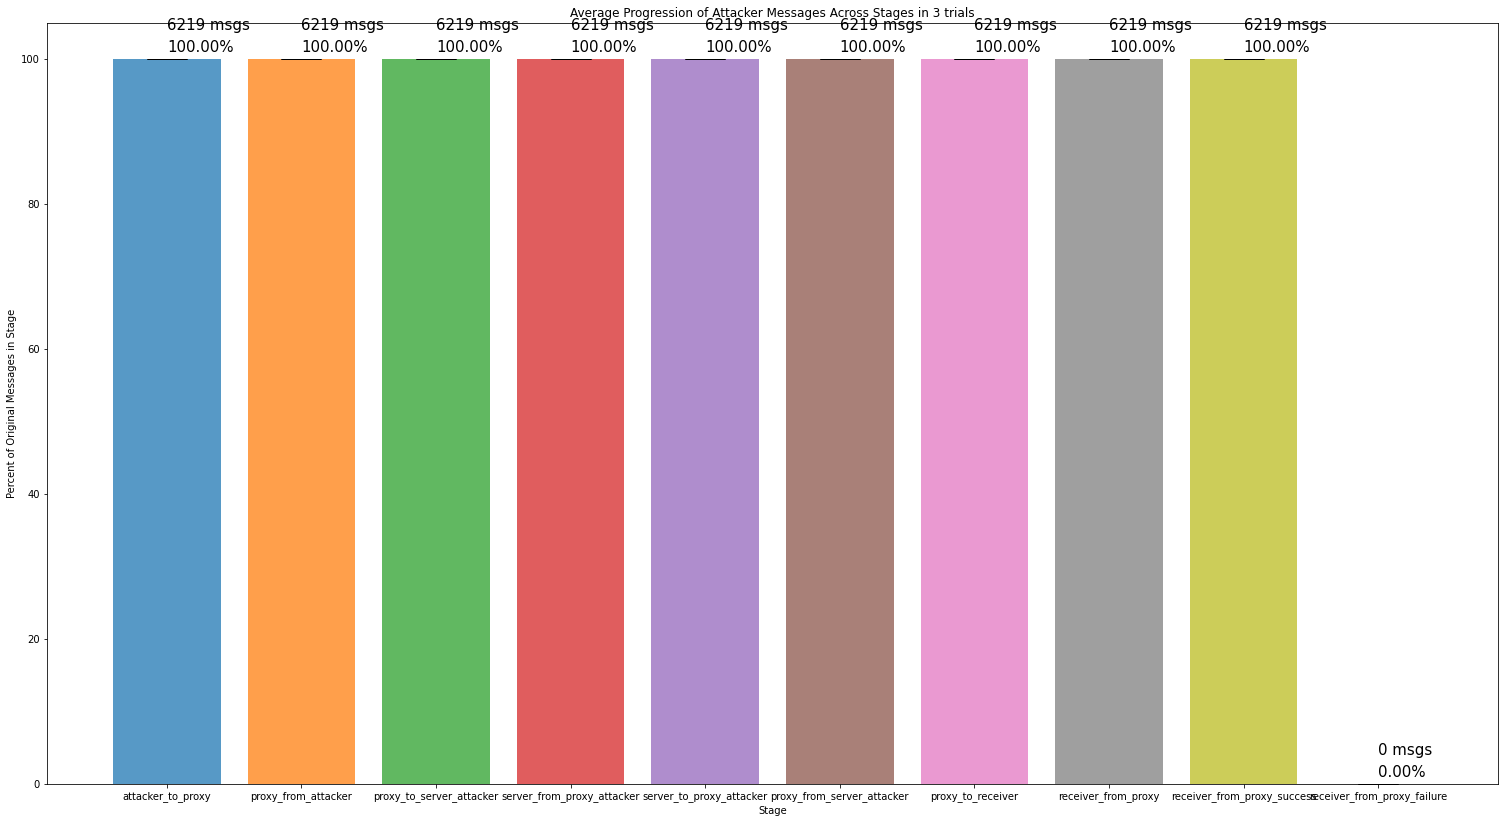

In [12]:
# Graph stages from attacker's perspective

stages = [
    "attacker_to_proxy_df",
    "proxy_from_attacker_df",
    "proxy_to_server_attacker_df",
    "server_from_proxy_attacker_df",
    "server_to_proxy_attacker_df",
    "proxy_from_server_attacker_df",
    "proxy_to_receiver_df",
    "receiver_from_proxy_df",
    "receiver_from_proxy_success_df",
    "receiver_from_proxy_failure_df",
]

percents = [list() for _ in range(len(stages))]
nums = [0 for _ in range(len(stages))]

for tn, td in sorted(trials.items()):
    print(f"{tn}...")
    base_message_nums = set(td.attacker_to_proxy_df.message_number.unique())
    for i, stage_name in enumerate(stages):
        stage_df = td[stage_name]
        pct = pct_containment(base_message_nums, set(stage_df.message_number.unique()))
        percents[i].append(pct)
        nums[i] = (pct/100) * len(base_message_nums)
        
avgs = list(map(np.average, percents))
stdevs = list(map(np.std, percents))

for i in range(len(stages)):
    name = stages[i]
    name = name.strip("_df")
    
    avg = avgs[i]
    err = stdevs[i]
    num = nums[i]
    plt.bar(name, avg, yerr=err, alpha=0.75, ecolor='black', capsize=20)
    plt.text(name, avg + 1, "{:.2f}%".format(avg), fontsize=15)
    plt.text(name, avg + 4, "{} msgs".format(int(num)), fontsize=15)

plt.title(f"Average Progression of Attacker Messages Across Stages in {len(trials)} trials")
plt.xlabel("Stage")
plt.ylabel("Percent of Original Messages in Stage")
plt.show()

1...
2...
3...


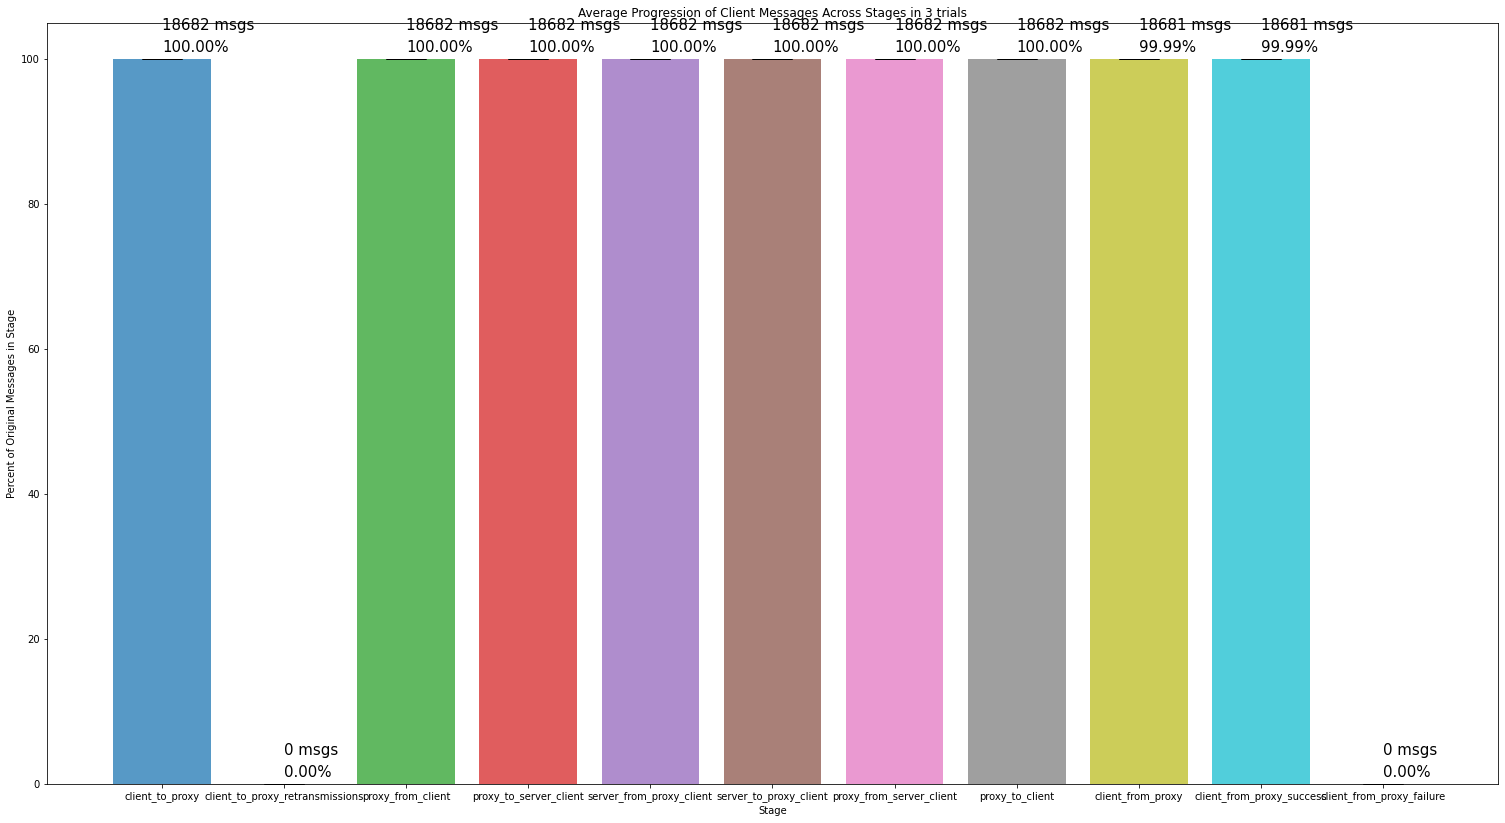

In [13]:
# Graph stages from client's perspective

stages = [
    "client_to_proxy_df",
    "client_to_proxy_retransmissions_df",
    "proxy_from_client_df",
    "proxy_to_server_client_df",
    "server_from_proxy_client_df",
    "server_to_proxy_client_df",
    "proxy_from_server_client_df",
    "proxy_to_client_df",
    "client_from_proxy_df",
    "client_from_proxy_success_df",
    "client_from_proxy_failure_df",
]

percents = [list() for _ in range(len(stages))]
nums = [0 for _ in range(len(stages))]

for tn, td in sorted(trials.items()):
    print(f"{tn}...")
    base_message_nums = set(td.client_to_proxy_df.message_number.unique())
    for i, stage_name in enumerate(stages):
        stage_df = td[stage_name]
        pct = pct_containment(base_message_nums, set(stage_df.message_number.unique()))
        percents[i].append(pct)
        nums[i] = (pct/100) * len(base_message_nums)
        
avgs = list(map(np.average, percents))
stdevs = list(map(np.std, percents))

for i in range(len(stages)):
    name = stages[i]
    name = name.strip("_df")
    
    avg = avgs[i]
    err = stdevs[i]
    num = nums[i]
    plt.bar(name, avg, yerr=err, alpha=0.75, ecolor='black', capsize=20)
    plt.text(name, avg + 1, "{:.2f}%".format(avg), fontsize=15)
    plt.text(name, avg + 4, "{} msgs".format(int(num)), fontsize=15)

plt.title(f"Average Progression of Client Messages Across Stages in {len(trials)} trials")
plt.xlabel("Stage")
plt.ylabel("Percent of Original Messages in Stage")
plt.show()

In [14]:
# Stats

# Response codes from server to proxy
http_codes = set()
for i, (tn, td) in enumerate(sorted(trials.items())):
    http_codes.update(td.proxy_from_server_df.http_response_code.unique())
print(f"http_codes: {http_codes}")
print()

# Client RPS
for i, (tn, td) in enumerate(sorted(trials.items())):
    num_msgs = len(td.client_to_proxy_df.message_number.unique())
    duration = td.client_to_proxy_df.message_timestamp.max() - td.client_to_proxy_df.message_timestamp.min()
    print(f"Trial {tn}: Client RPS = {num_msgs / duration}")
print()

# Attacker RPS
for i, (tn, td) in enumerate(sorted(trials.items())):
    num_msgs = len(td.attacker_to_proxy_df.message_number.unique())
    duration = td.attacker_to_proxy_df.message_timestamp.max() - td.attacker_to_proxy_df.message_timestamp.min()
    print(f"Trial {tn}: Attacker RPS = {num_msgs / duration}")

http_codes: {200.0}

Trial 1: Client RPS = 377.54801406990447
Trial 2: Client RPS = 374.82638293690457
Trial 3: Client RPS = 383.54112908304484

Trial 1: Attacker RPS = 119.32847209343777
Trial 2: Attacker RPS = 120.46794987781713
Trial 3: Attacker RPS = 119.31308589368403


1...


/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


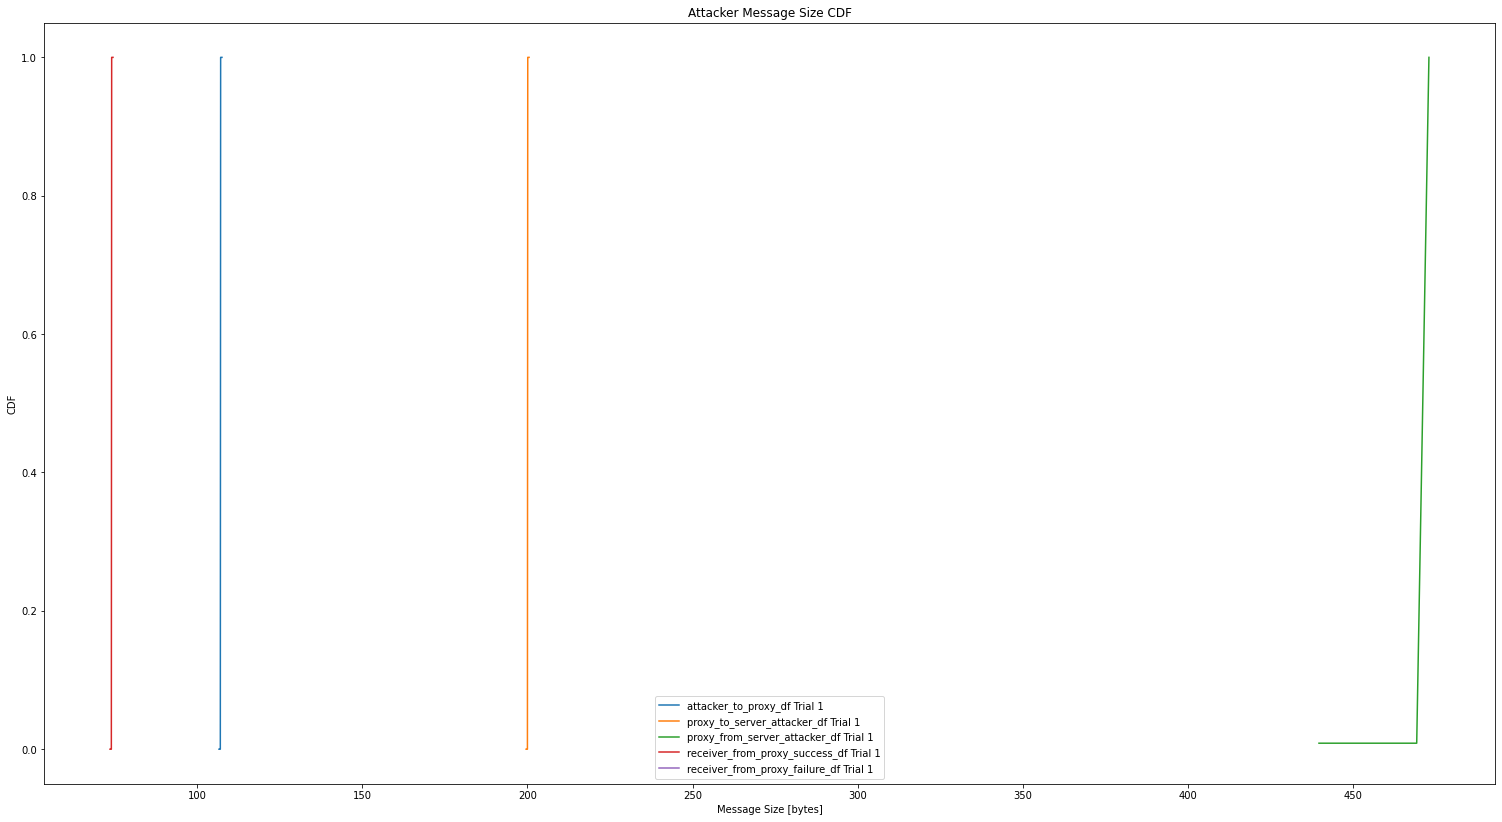

In [15]:
# Plot message size CDF

stages = [
    "attacker_to_proxy_df",
    "proxy_to_server_attacker_df",
    "proxy_from_server_attacker_df",
    "receiver_from_proxy_success_df",
    "receiver_from_proxy_failure_df",
]

for i, (tn, td) in enumerate(sorted(trials.items())):
    print(f"{tn}...")
    
    for i, stage_name in enumerate(stages):
        stage_df = td[stage_name]
        stage_df["stage_name"] = stage_name
        
        msg_sizes = stage_df.message_size
        count, bins_count = np.histogram(msg_sizes, bins=10)
        pdf = count / sum(count)
        cdf = np.cumsum(pdf)
            
        plt.plot(bins_count[1:], cdf, label=f"{stage_name} Trial {tn}")
        plt.title("Attacker Message Size CDF")
        plt.ylabel("CDF")
        plt.xlabel("Message Size [bytes]")
        plt.legend()
        
    break
    
plt.legend()
plt.show()

1... Attacker
2... Attacker
3... Attacker
1... Client
2... Client
3... Client


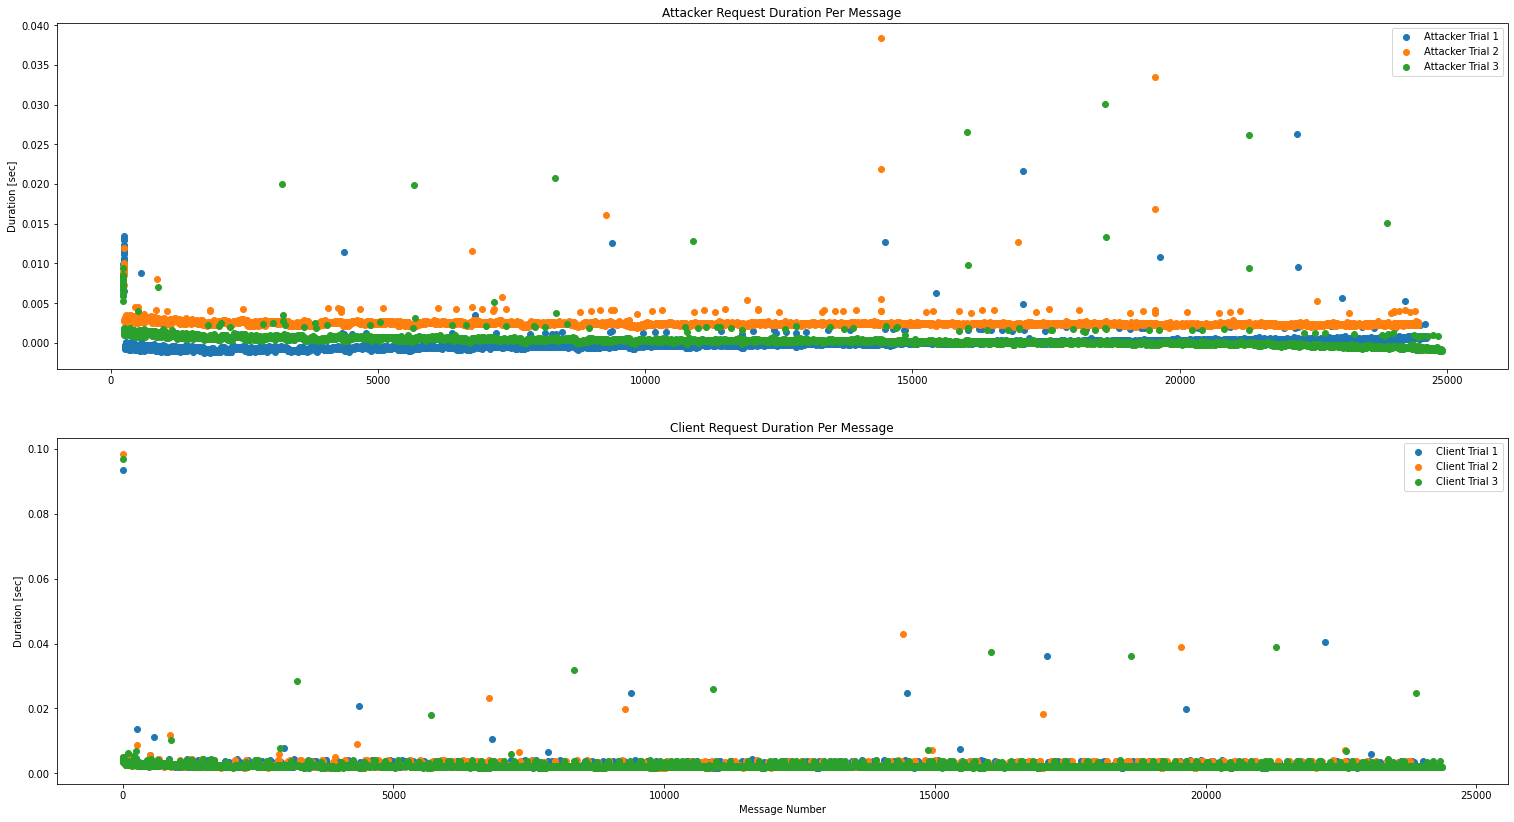

In [16]:
# Plot message time differences

fig, ax = plt.subplots(2, 1)

# Attacker
for i, (tn, td) in enumerate(sorted(trials.items())):
    print(f"{tn}... Attacker")
    jdf = pd.merge(td.attacker_to_proxy_df, td.receiver_from_proxy_df, how="inner", on="message_number", suffixes=("_src", "_dst"))
    jdf["timediff"] = jdf["message_timestamp_dst"] - jdf["message_timestamp_src"]
    ax[0].scatter(jdf.message_number, jdf.timediff, cmap="plasma", label=f"Attacker Trial {tn}")
    ax[0].set_title("Attacker Request Duration Per Message")
    ax[0].set_ylabel("Duration [sec]")
    ax[0].legend()
    
# Client
for i, (tn, td) in enumerate(sorted(trials.items())):
    print(f"{tn}... Client")
    ndf = pd.merge(td.client_to_proxy_df, td.client_from_proxy_df, how="inner", on="message_number", suffixes=("_src", "_dst"))
    ndf["timediff"] = ndf["message_timestamp_dst"] - ndf["message_timestamp_src"]
    ax[1].scatter(ndf.message_number, ndf.timediff, label=f"Client Trial {tn}")
    ax[1].set_title("Client Request Duration Per Message")
    ax[1].set_ylabel("Duration [sec]")
    ax[1].legend()

plt.xlabel("Message Number")
plt.legend()
plt.show()

1... Attacker
2... Attacker
3... Attacker
1... Client
2... Client
3... Client


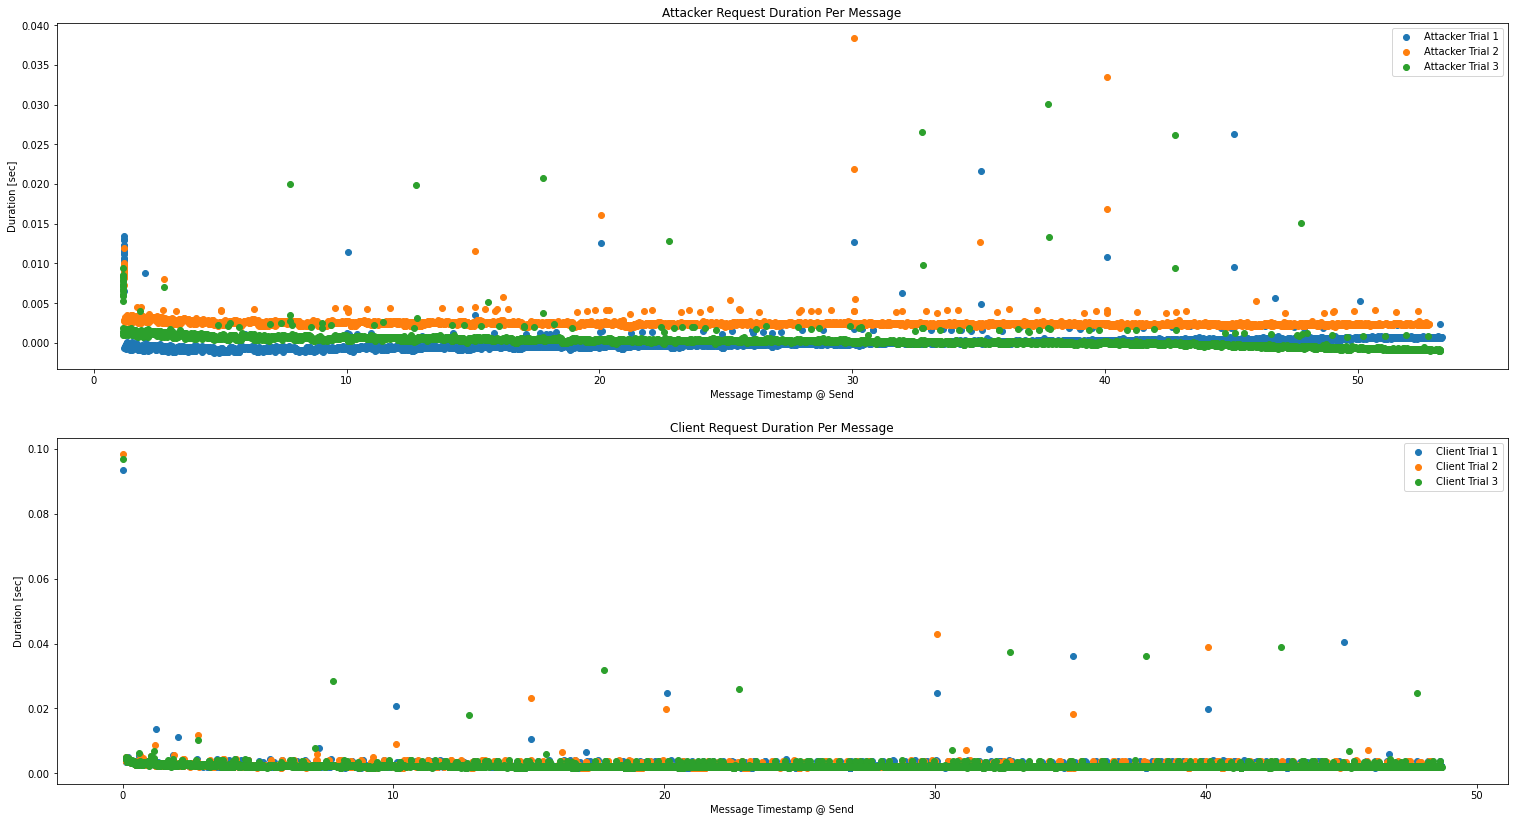

In [17]:
# Graph duration vs timestamp

fig, ax = plt.subplots(2, 1)

for i, (tn, td) in enumerate(sorted(trials.items())):
    print(f"{tn}... Attacker")
    to_proxy_to_receiver_merged_df = pd.merge(td.attacker_to_proxy_df, td.receiver_from_proxy_df, how="inner", on="message_number", suffixes=("_src", "_dst"))
    to_proxy_to_receiver_merged_df["duration"] = to_proxy_to_receiver_merged_df["message_timestamp_dst"] - to_proxy_to_receiver_merged_df["message_timestamp_src"]
    
    y = to_proxy_to_receiver_merged_df["duration"]
    x = to_proxy_to_receiver_merged_df["relative_timestamp_src"]
    
    ax[0].scatter(x, y, label=f"Attacker Trial {tn}")
    ax[0].set_title("Attacker Request Duration Per Message")
    ax[0].set_ylabel("Duration [sec]")
    ax[0].set_xlabel("Message Timestamp @ Send")
    ax[0].legend()

for i, (tn, td) in enumerate(sorted(trials.items())):
    print(f"{tn}... Client")
    to_from_proxy_merged_df = pd.merge(td.client_to_proxy_df, td.client_from_proxy_df, how="inner", on="message_number", suffixes=("_src", "_dst"))
    to_from_proxy_merged_df["duration"] = to_from_proxy_merged_df["message_timestamp_dst"] - to_from_proxy_merged_df["message_timestamp_src"]
    
    y = to_from_proxy_merged_df["duration"]
    x = to_from_proxy_merged_df["relative_timestamp_src"]
    
    ax[1].scatter(x, y, label=f"Client Trial {tn}")
    ax[1].set_title("Client Request Duration Per Message")
    ax[1].set_ylabel("Duration [sec]")
    ax[1].set_xlabel("Message Timestamp @ Send")
    ax[1].legend()
    
plt.xlabel("Message Timestamp @ Send")
plt.legend()
plt.show()

1... Attacker
2... Attacker
3... Attacker
1... Client
2... Client
3... Client


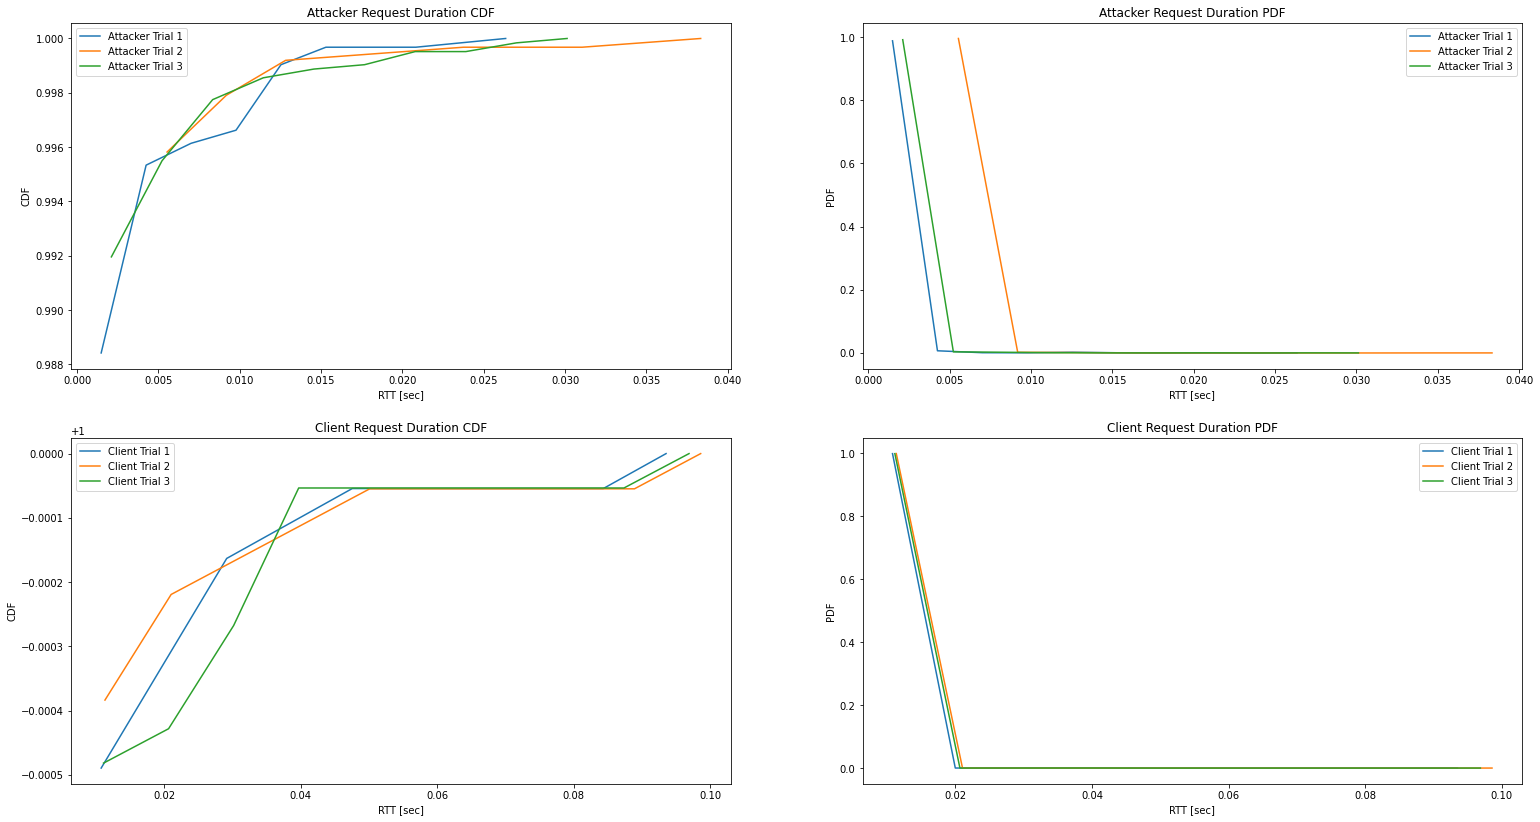

In [18]:
# Graph CDF/PDF of message durations

fig, ax = plt.subplots(2, 2)

for i, (tn, td) in enumerate(sorted(trials.items())):
    print(f"{tn}... Attacker")
    to_proxy_to_receiver_merged_df = pd.merge(td.attacker_to_proxy_df, td.receiver_from_proxy_df, how="inner", on="message_number", suffixes=("_src", "_dst"))
    to_proxy_to_receiver_merged_df["duration"] = to_proxy_to_receiver_merged_df["message_timestamp_dst"] - to_proxy_to_receiver_merged_df["message_timestamp_src"]
    durations = to_proxy_to_receiver_merged_df["duration"]
    durations = durations.dropna()
    
    count, bins_count = np.histogram(durations, bins=10)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    
    # CDF
    ax[0,0].plot(bins_count[1:], cdf, label=f"Attacker Trial {tn}")
    ax[0,0].set_title("Attacker Request Duration CDF")
    ax[0,0].set_ylabel("CDF")
    ax[0,0].set_xlabel("RTT [sec]")
    ax[0,0].legend()
    
    # PDF
    ax[0,1].plot(bins_count[1:], pdf, label=f"Attacker Trial {tn}")
    ax[0,1].set_title("Attacker Request Duration PDF")
    ax[0,1].set_ylabel("PDF")
    ax[0,1].set_xlabel("RTT [sec]")
    ax[0,1].legend()

for i, (tn, td) in enumerate(sorted(trials.items())):
    print(f"{tn}... Client")
    to_from_proxy_merged_df = pd.merge(td.client_to_proxy_df, td.client_from_proxy_df, how="inner", on="message_number", suffixes=("_src", "_dst"))
    to_from_proxy_merged_df["duration"] = to_from_proxy_merged_df["message_timestamp_dst"] - to_from_proxy_merged_df["message_timestamp_src"]
    durations = to_from_proxy_merged_df["duration"]
    durations = durations.dropna()
    
    count, bins_count = np.histogram(durations, bins=10)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    
    # CDF
    ax[1,0].plot(bins_count[1:], cdf, label=f"Client Trial {tn}")
    ax[1,0].set_title("Client Request Duration CDF")
    ax[1,0].set_ylabel("CDF")
    ax[1,0].set_xlabel("RTT [sec]")
    ax[1,0].legend()
    
    # PDF
    ax[1,1].plot(bins_count[1:], pdf, label=f"Client Trial {tn}")
    ax[1,1].set_title("Client Request Duration PDF")
    ax[1,1].set_ylabel("PDF")
    ax[1,1].set_xlabel("RTT [sec]")
    ax[1,1].legend()
    
plt.show()

1...
2...
3...


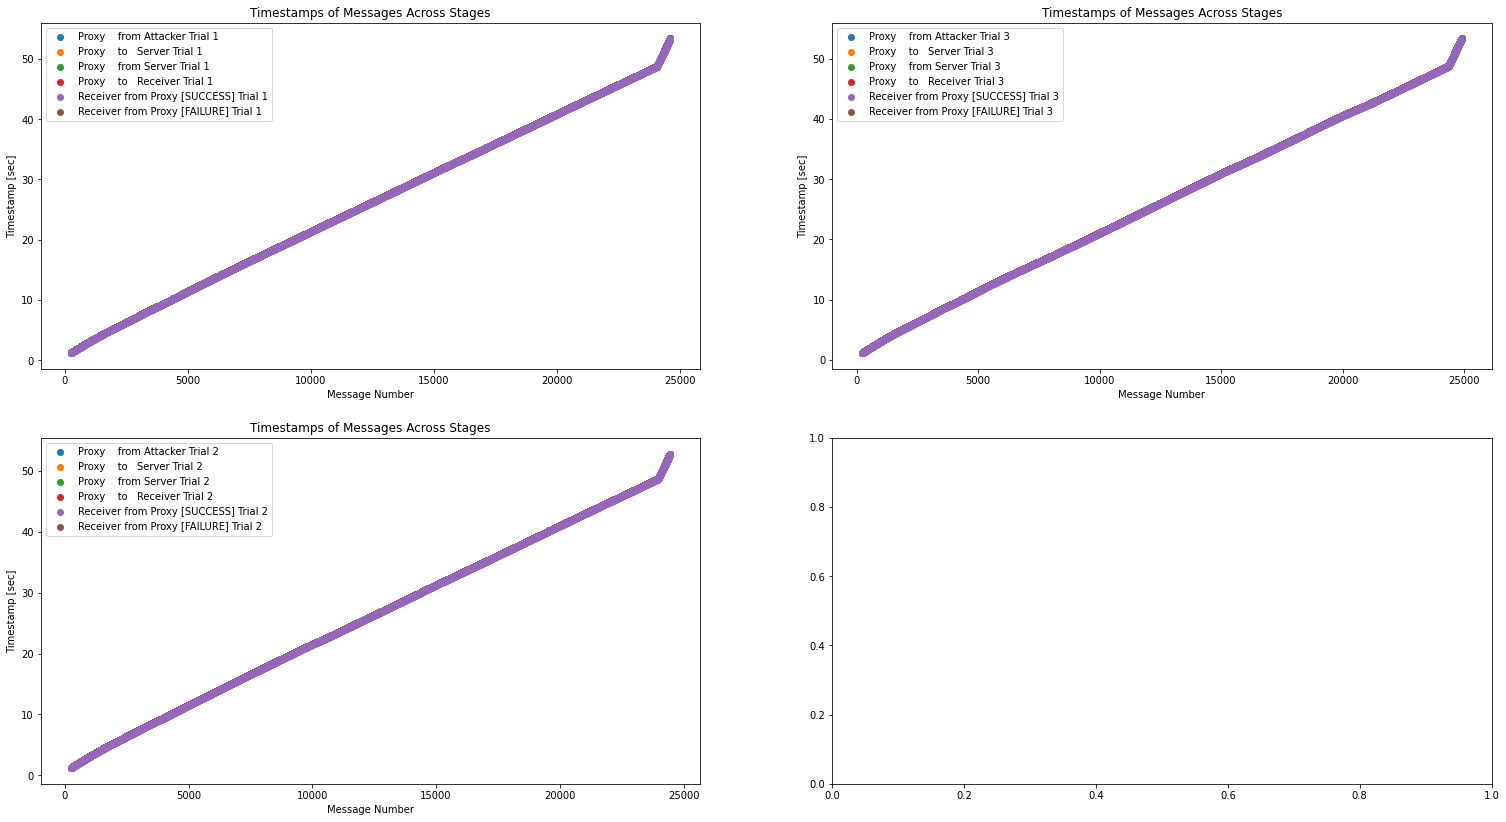

In [19]:
# Graph attacker timestamps

L = len(trials)
if L % 2 != 0:
    L += 1
ox = 2
oy = max(2, L // 2)
fig, ax = plt.subplots(ox, oy)

for i, (tn, td) in enumerate(sorted(trials.items())):
    print(f"{tn}...")
    
    # Choose which things to plot
    to_plot = [
#         (td.attacker_to_proxy_df,   f"Attacker to   Proxy Trial {tn}"),
        (td.proxy_from_attacker_df, f"Proxy    from Attacker Trial {tn}"),
        (td.proxy_to_server_attacker_df,     f"Proxy    to   Server Trial {tn}"),
#         (td.server_from_proxy_attacker_df,   f"Server   from Proxy Trial {tn}"),
#         (td.server_to_proxy_attacker_df,     f"Server   to   Proxy Trial {tn}"),
        (td.proxy_from_server_attacker_df,   f"Proxy    from Server Trial {tn}"),
        (td.proxy_to_receiver_df,   f"Proxy    to   Receiver Trial {tn}"),
#         (td.receiver_from_proxy_df, f"Receiver from Proxy Trial {tn}"),
        (td.receiver_from_proxy_success_df, f"Receiver from Proxy [SUCCESS] Trial {tn}"),
        (td.receiver_from_proxy_failure_df, f"Receiver from Proxy [FAILURE] Trial {tn}"),
    ]
    
    # Plot the things
    ii, jj = ((i % ox), (i // ox))
    for df, label in to_plot:
        ax[ii, jj].scatter(df.message_number, df.relative_timestamp, label=label)
    ax[ii, jj].set_title("Timestamps of Messages Across Stages")
    ax[ii, jj].set_xlabel("Message Number")
    ax[ii, jj].set_ylabel("Timestamp [sec]")
    ax[ii, jj].legend()

plt.show()

1...
2...
3...


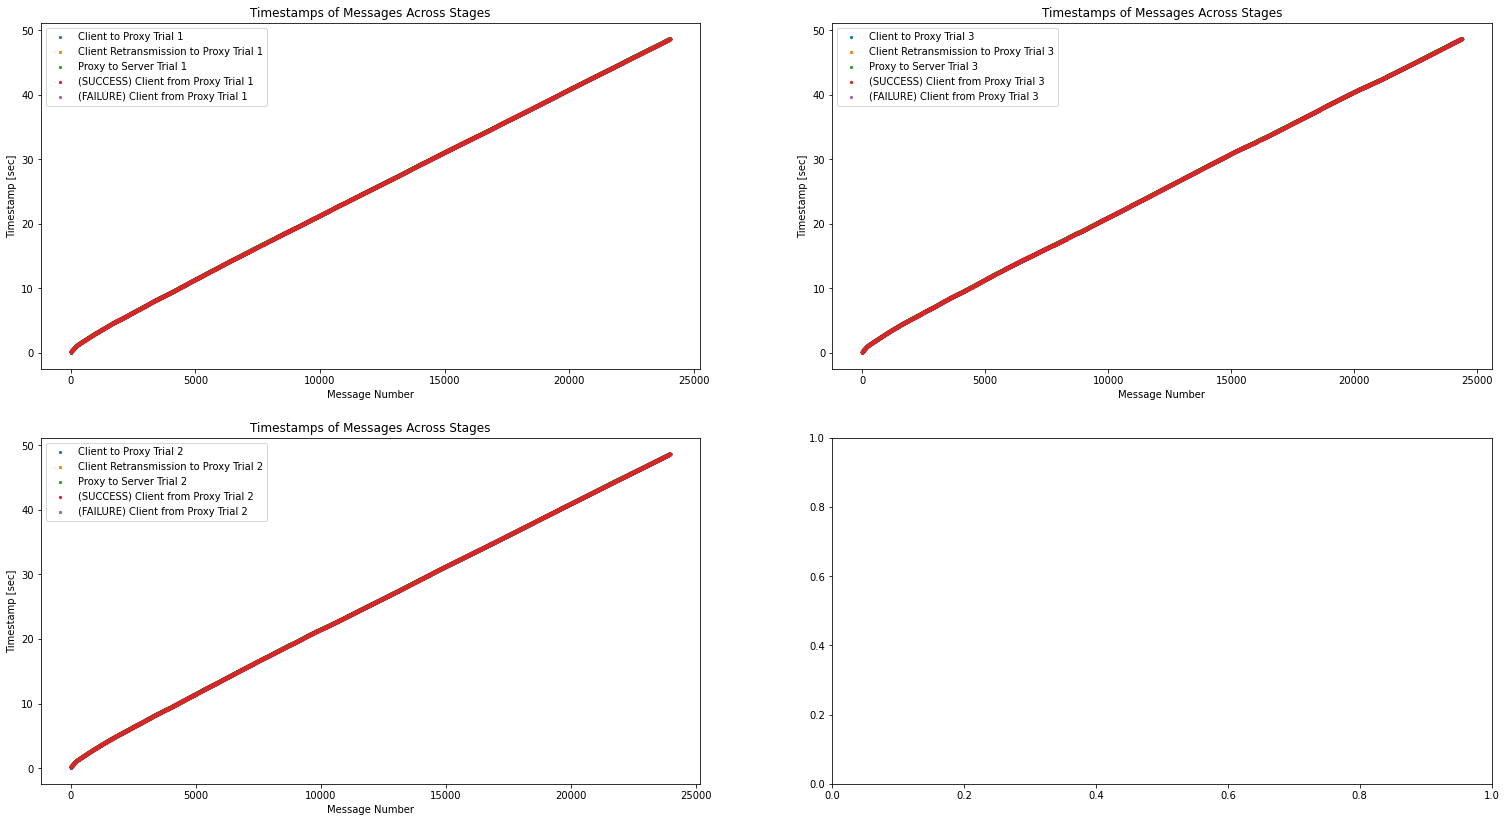

In [20]:
# Graph client timestamps

L = len(trials)
if L % 2 != 0:
    L += 1
ox = 2
oy = max(2, L // 2)
fig, ax = plt.subplots(ox, oy)

for i, (tn, td) in enumerate(sorted(trials.items())):
    print(f"{tn}...")
    
    # Choose which things to plot
    to_plot = [
        (td.client_to_proxy_df,                 f"Client to Proxy Trial {tn}"),
        (td.client_to_proxy_retransmissions_df, f"Client Retransmission to Proxy Trial {tn}"),
#         (td.proxy_from_client_df,               f"Proxy from Client Trial {tn}"),
        (td.proxy_to_server_client_df,          f"Proxy to Server Trial {tn}"),
#         (td.proxy_from_server_client_df,        f"Proxy from Server Trial {tn}"),
#         (td.proxy_to_client_df,                 f"Proxy to Client Trial {tn}"),
#         (td.client_from_proxy_df,               f"Client from Proxy Trial {tn}"),
        (td.client_from_proxy_success_df,       f"(SUCCESS) Client from Proxy Trial {tn}"),
        (td.client_from_proxy_failure_df,       f"(FAILURE) Client from Proxy Trial {tn}"),
    ]
    
    # Plot the things
    ii, jj = ((i % ox), (i // ox))
    for df, label in to_plot:
        ax[ii, jj].scatter(df.message_number, df.relative_timestamp, s=5, label=label)
    ax[ii, jj].set_title("Timestamps of Messages Across Stages")
    ax[ii, jj].set_xlabel("Message Number")
    ax[ii, jj].set_ylabel("Timestamp [sec]")
    ax[ii, jj].legend()

plt.show()